<a href="https://colab.research.google.com/github/PerisN/Power-Consumption-Forecasting/blob/main/Power_Consumption_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries

import numpy as np
import pandas as pd

import os
from datetime import datetime


from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
import seaborn as sns
 
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss ,acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

from prophet import Prophet 
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_plotly

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data

df = pd.read_csv('/content/drive/MyDrive/Time_series_analysis_and_forecast_DATASET.csv')
df

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.21500,3.6900,23.710
1,2010-09-01 01:00:00,15.8,1669.19500,3.6900,22.635
2,2010-09-01 02:00:00,15.8,1491.98000,3.6900,22.565
3,2010-09-01 03:00:00,15.8,1330.76000,3.6900,18.910
4,2010-09-01 04:00:00,15.8,1247.94000,3.6900,18.030
...,...,...,...,...,...
92011,2021-02-28 19:00:00,24.3,449.63625,5.4848,117.925
92012,2021-02-28 20:00:00,24.3,815.59975,5.4848,87.880
92013,2021-02-28 21:00:00,24.3,745.12325,5.4848,62.060
92014,2021-02-28 22:00:00,24.3,694.95150,5.4848,62.000


There are values from 2010-09-01 00:00:00 to 2021-02-28 23:00:00

In [3]:
df.dtypes

FullDate      object
Tmax         float64
SysLoad      float64
GasPrice     float64
ElecPrice    float64
dtype: object

In [4]:
# Change the FullDate column into its appropriate data type

df["FullDate"] = pd.to_datetime(df["FullDate"]) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FullDate   92016 non-null  datetime64[ns]
 1   Tmax       92016 non-null  float64       
 2   SysLoad    92016 non-null  float64       
 3   GasPrice   92016 non-null  float64       
 4   ElecPrice  92016 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.5 MB


In [5]:
print('Rows :', df.shape[0])
print('Columns :', df.shape[1])
print('\nFeatures :', df.columns.tolist())
print('\nMissing Values : \n' , df.isnull().any())
print('\nUnique values : \n' , df.nunique())

Rows : 92016
Columns : 5

Features : ['FullDate', 'Tmax', 'SysLoad', 'GasPrice', 'ElecPrice']

Missing Values : 
 FullDate     False
Tmax         False
SysLoad      False
GasPrice     False
ElecPrice    False
dtype: bool

Unique values : 
 FullDate     92016
Tmax           328
SysLoad      91933
GasPrice      2128
ElecPrice    31855
dtype: int64


There aren't any null values and there are 92016 unique rows in datetime column implying there are no duplicates.

In [6]:
df.describe()

,Tmax,SysLoad,GasPrice,ElecPrice
count,92016.000000,92016.000000,92016.000000,92016.000000
mean,231.696688,797.623357,6.016163,65.798356
std,4562.128748,613.520156,2.608116,213.144084
min,9.900000,-1596.810100,0.000000,-924.820000
25%,17.300000,417.119800,3.936900,31.543750
50%,21.900000,856.467925,5.165600,48.715000
75%,27.600000,1221.293675,8.023300,76.495000
max,99999.900000,3264.166300,29.990000,14700.000000


In [7]:
df1 = df.copy()

In [8]:
df = df.set_index('FullDate')
df.head(3)

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565


In [9]:
# Downsample to daily data points 

df = df.resample( 'D' ).mean()
print(df.shape)
df.head()

(3834, 4)


,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,15.8,1731.890833,3.69,114.654167
2010-09-02,15.4,1620.791250,3.69,23.783750
2010-09-03,18.3,1736.073333,4.45,21.040625
2010-09-04,13.7,1484.920208,3.39,20.928125
2010-09-05,14.9,1483.808750,4.45,20.856458


Setting the date as index will make our analysis and time series plots much more understandable.

In [10]:
df.loc['2015-01' : '2015-05']

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2015-01-01,37.0,1052.206473,3.6107,31.325625
2015-01-02,44.1,1267.868785,3.7901,68.163958
2015-01-03,38.2,1028.663671,2.8500,34.069375
2015-01-04,30.5,515.240635,4.0550,23.604375
2015-01-05,34.9,893.188977,4.4789,40.524792
...,...,...,...,...
2015-05-27,19.7,995.568392,4.2500,83.880417
2015-05-28,19.2,835.488640,4.1633,29.817083
2015-05-29,17.1,1266.116227,4.1600,40.628125


### **How do the variables change with time?**

<Figure size 1800x600 with 0 Axes>

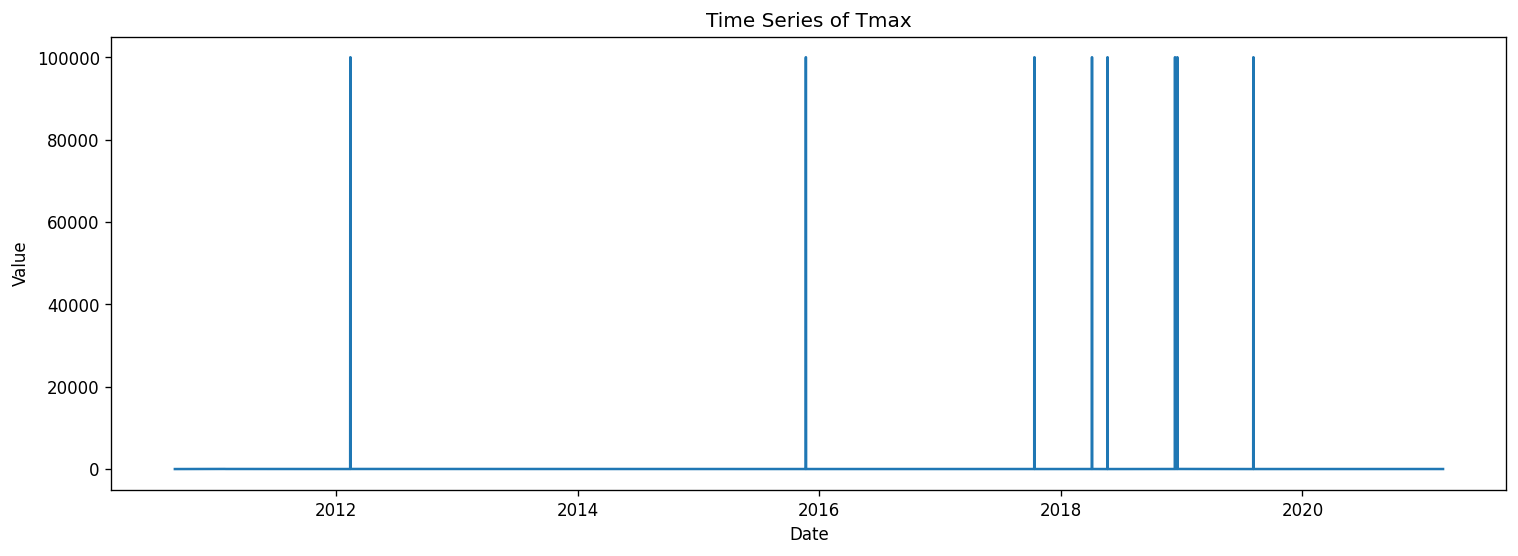

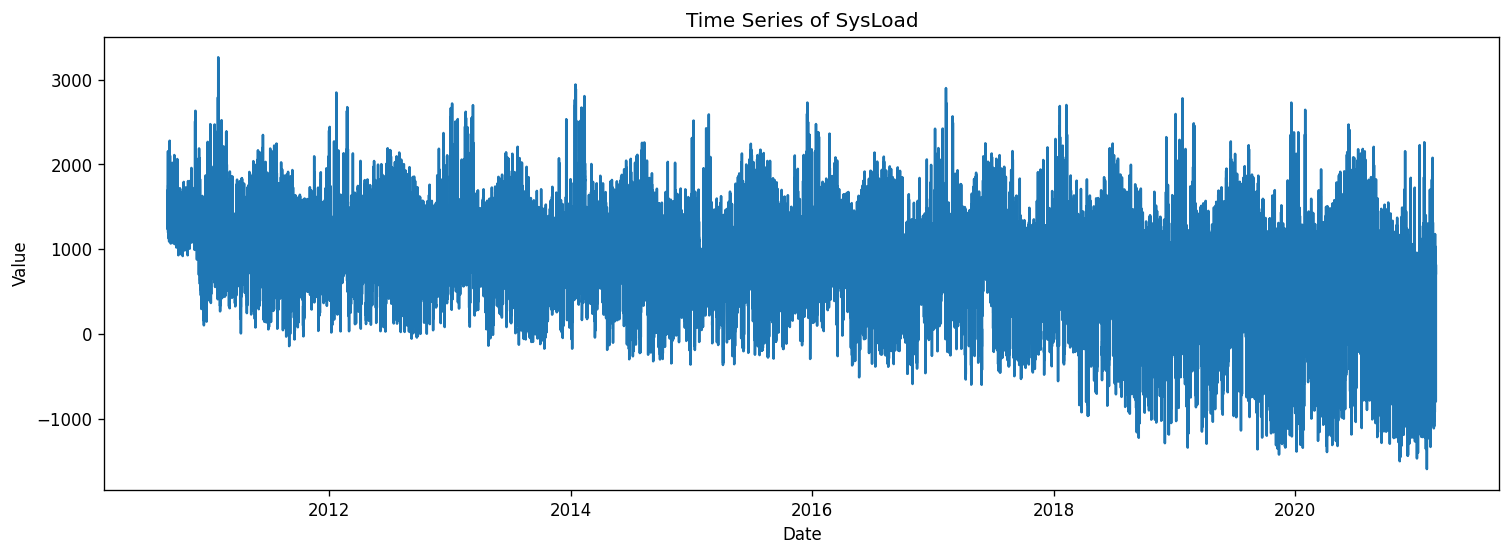

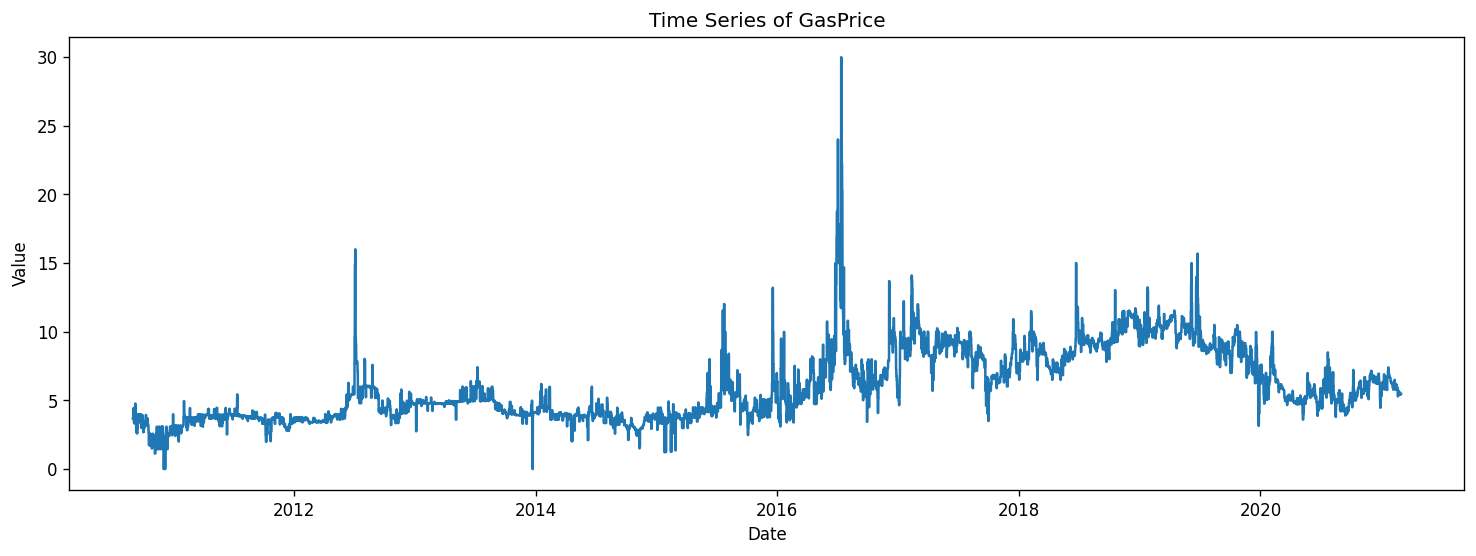

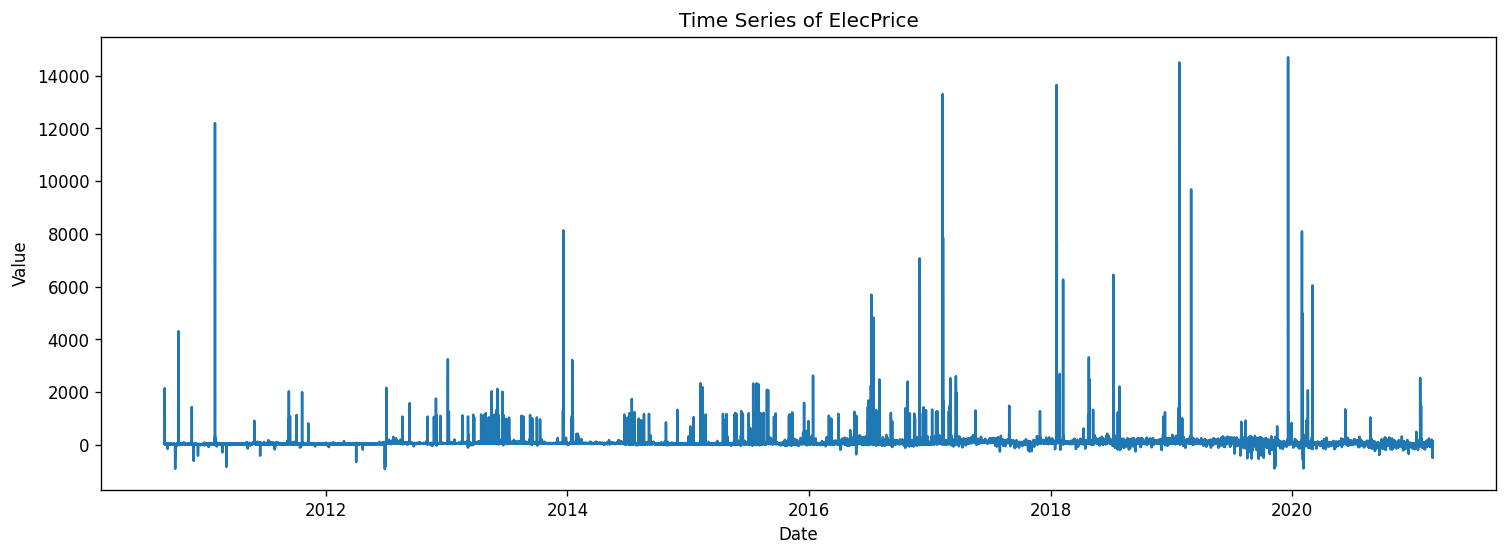

In [58]:
plt.figure(figsize=(15, 5))

columns = ['Tmax','SysLoad', 'GasPrice','ElecPrice']

for column in columns:
    plt.figure(figsize=(15, 5))
    plt.plot(df1['FullDate'], df1[column])
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Time Series of {column}')
    plt.show();


**Stationarity Test**

In [15]:
# ElecPrice ADF Test
result = adfuller(df.ElecPrice.values, autolag='AIC')
print(f'ADF Statistic: {result[0]:.6f}')
print(f'p-value: {result[1]:.6f}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value:.4f}')

# KPSS Test
result = kpss(df.ElecPrice.values, regression='c')
print(f'\nKPSS Statistic: {result[0]:.6f}')
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value:.4f}')

ADF Statistic: -8.269054
p-value: 0.000000
Critial Values:
   1%, -3.4321
Critial Values:
   5%, -2.8623
Critial Values:
   10%, -2.5672

KPSS Statistic: 2.331077
p-value: 0.010000
Critial Values:
   10%, 0.3470
Critial Values:
   5%, 0.4630
Critial Values:
   2.5%, 0.5740
Critial Values:
   1%, 0.7390


The p-value obtained from the ADF test is less than 0.05 so we reject the null hypothesis that the series is non-stationary. The ADF statistic is also  significantly lower than the critical values

The p_value is less than 0.05 for the KPSS so we fail to reject the null hypothesis that the series is stationary. 

In [16]:
# GasPrice ADF Test
result = adfuller(df.GasPrice.values, autolag='AIC')
print(f'ADF Statistic: {result[0]:.6f}')
print(f'p-value: {result[1]:.6f}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value:.4f}')

# KPSS Test
result = kpss(df.ElecPrice.values, regression='c')
print(f'\nKPSS Statistic: {result[0]:.6f}')
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value:.4f}')

ADF Statistic: -2.902767
p-value: 0.045027
Critial Values:
   1%, -3.4321
Critial Values:
   5%, -2.8623
Critial Values:
   10%, -2.5672

KPSS Statistic: 2.331077
p-value: 0.010000
Critial Values:
   10%, 0.3470
Critial Values:
   5%, 0.4630
Critial Values:
   2.5%, 0.5740
Critial Values:
   1%, 0.7390


In [17]:
# SysLoad ADF Test
result = adfuller(df.SysLoad.values, autolag='AIC')
print(f'ADF Statistic: {result[0]:.6f}')
print(f'p-value: {result[1]:.6f}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value:.4f}')

# KPSS Test
result = kpss(df.ElecPrice.values, regression='c')
print(f'\nKPSS Statistic: {result[0]:.6f}')
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value:.4f}')

ADF Statistic: -3.690159
p-value: 0.004254
Critial Values:
   1%, -3.4321
Critial Values:
   5%, -2.8623
Critial Values:
   10%, -2.5672

KPSS Statistic: 2.331077
p-value: 0.010000
Critial Values:
   10%, 0.3470
Critial Values:
   5%, 0.4630
Critial Values:
   2.5%, 0.5740
Critial Values:
   1%, 0.7390


##**Modeling**

#### Univariate Forecasting

In [18]:
df_1 = df.reset_index()[['FullDate','ElecPrice']].rename(columns={ "FullDate" : "ds" , "ElecPrice" : "y" }) 
df_1.head() 

,ds,y
0,2010-09-01,114.654167
1,2010-09-02,23.783750
2,2010-09-03,21.040625
3,2010-09-04,20.928125
4,2010-09-05,20.856458


In [19]:
# Split dataset into train and test

train = df_1[:2757]
test = df_1[2757:]
test.shape

(1077, 2)

In [ ]:
m = Prophet()
m.fit(train) 

In [21]:
# Predictions

future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()  # Displaying various results in table format.

,ds,yhat,yhat_lower,yhat_upper
3829,2021-02-24,144.535060,20.430937,269.523869
3830,2021-02-25,147.320609,35.336970,269.777009
3831,2021-02-26,137.603721,16.621238,273.572749
3832,2021-02-27,123.297323,-0.110334,239.248574
3833,2021-02-28,119.627896,2.457080,241.875184


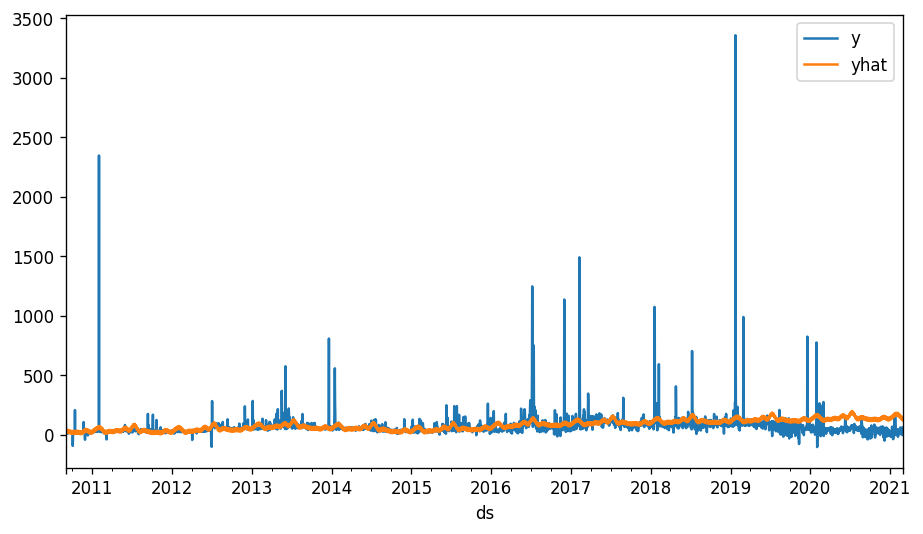

In [22]:
pd.concat([df_1.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis=1).plot();

Actual values have pikes that our model isn't able to predict

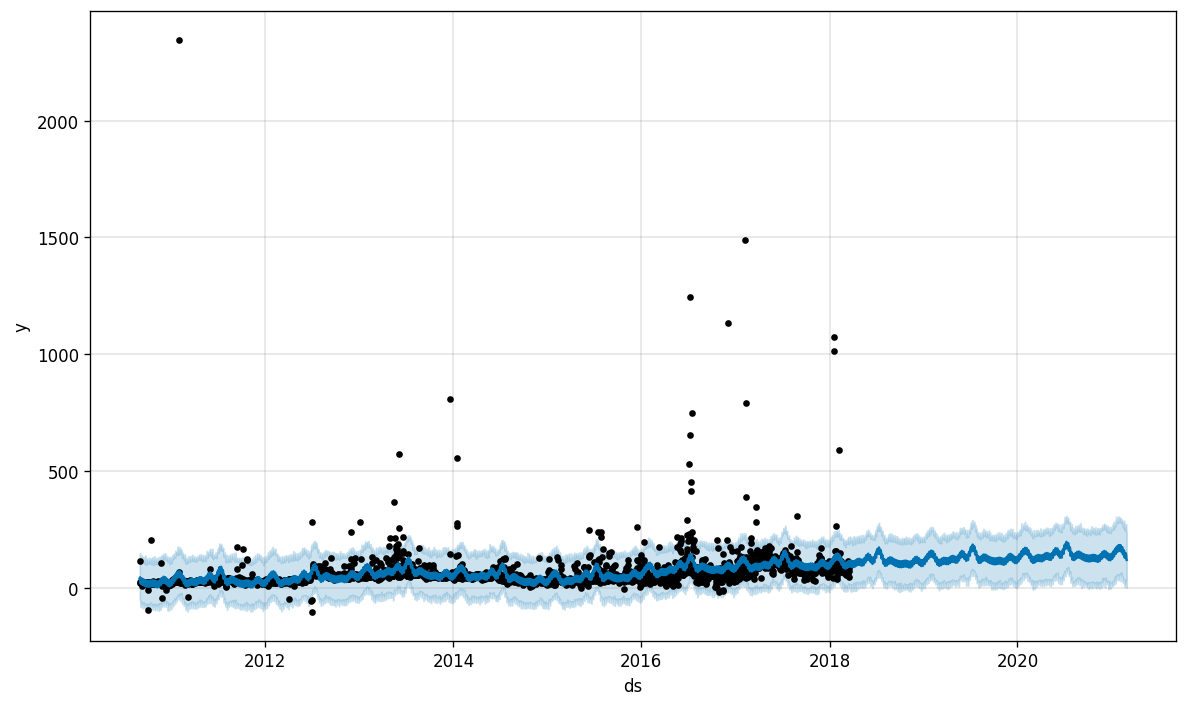

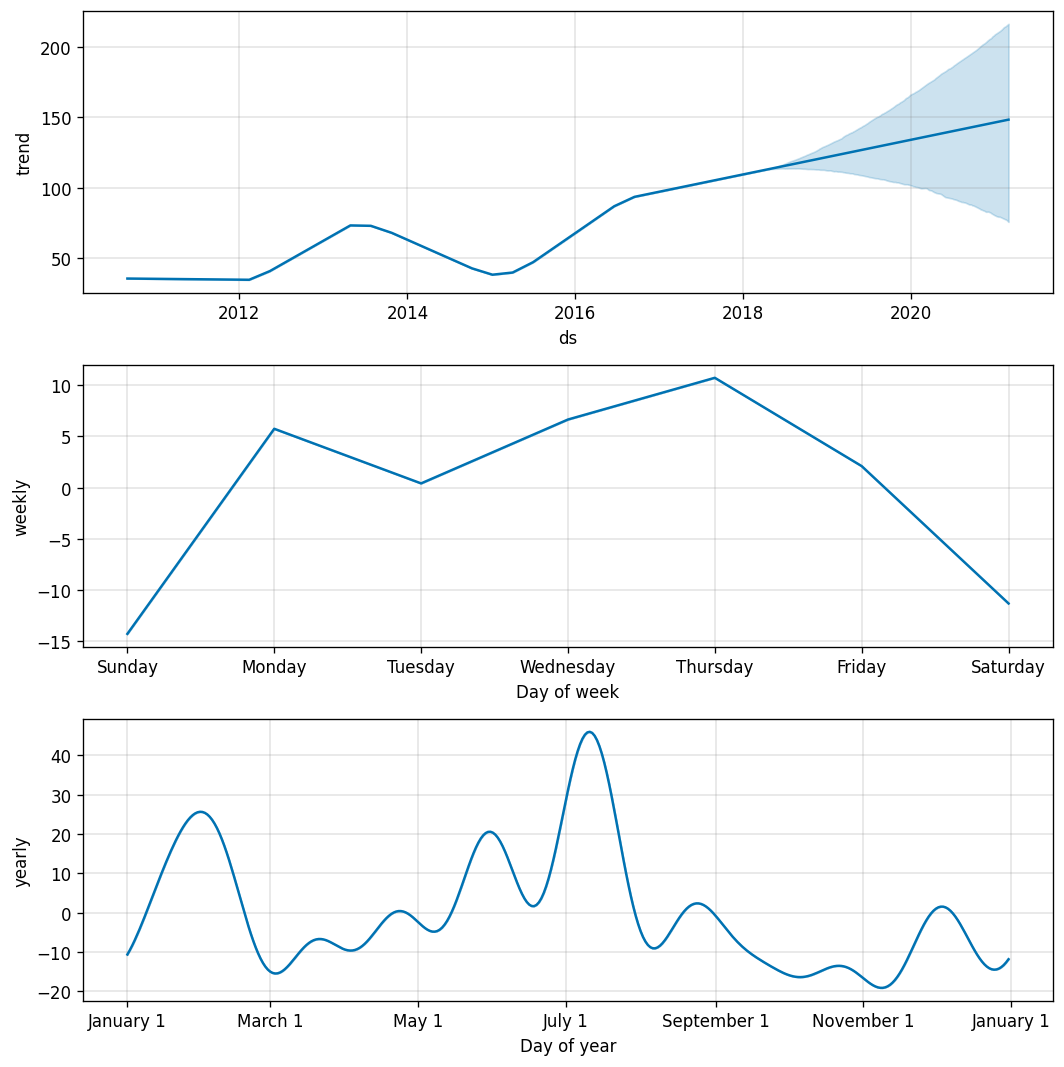

In [23]:
fig1 = m.plot(forecast) # Plot the fit to past data and future forcast.
fig2 = m.plot_components(forecast) # Plot breakdown of components.
plt.show()

In [26]:
# Evaluation

predictions = forecast[2757:]['yhat'].values
test = test['y'].values

# Calculate the MSE and MAE
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)

print(f'{mse = :.2f}')
print(f'{rmse = :.2f}')
print(f'{mae = :.2f}')
print(f'{mape = :.2f}')

mse = 17947.82
rmse = 133.97
mae = 72.66
mape = 5.48


In [27]:
# mape

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape = mape(test,predictions)
print(f'{mape = :.2f}')

mape = 548.24


In [28]:
#rmse

def rmse(actual,pred):
  actual, pred = np.array(actual), np.array(pred)
  return np.sqrt(mean_squared_error(actual,pred))

rmse = rmse(test,predictions)
print(f'{rmse = :.2f}')

rmse = 133.97


#### Multivariate Forecasting

In [30]:
df_2 = df.reset_index()[['FullDate', 'ElecPrice', 'SysLoad', 'Tmax', 'GasPrice']].rename(columns={ "FullDate" : "ds" , "ElecPrice" : 'y', 'SysLoad' : 'add1','Tmax': 'add2','GasPrice': 'add3'}) 
df_2.head() 

,ds,y,add1,add2,add3
0,2010-09-01,114.654167,1731.890833,15.8,3.69
1,2010-09-02,23.783750,1620.791250,15.4,3.69
2,2010-09-03,21.040625,1736.073333,18.3,4.45
3,2010-09-04,20.928125,1484.920208,13.7,3.39
4,2010-09-05,20.856458,1483.808750,14.9,4.45


In [31]:
df_2.corr()

,y,add1,add2,add3
y,1.000000,0.170524,0.004748,0.352420
add1,0.170524,1.000000,-0.012249,-0.268321
add2,0.004748,-0.012249,1.000000,0.030173
add3,0.352420,-0.268321,0.030173,1.000000


In [32]:
# Split dataset into train and test

train = df_2[:2757]
test = df_2[2757:]

In [ ]:
m2 = Prophet() 

m2.add_regressor('add1', standardize=False)
m2.add_regressor('add2', standardize=False)
m2.add_regressor('add3', standardize=False)

m2.fit(train) 

In [34]:
# Predictions

future2 = m2.make_future_dataframe(periods=len(test))
future2.tail()

,ds
3829,2021-02-24
3830,2021-02-25
3831,2021-02-26
3832,2021-02-27
3833,2021-02-28


In [35]:
future2['add1'] = df_2['add1']
future2['add2'] = df_2['add2']
future2['add3'] = df_2['add3']

In [36]:
future2

,ds,add1,add2,add3
0,2010-09-01,1731.890833,15.8,3.6900
1,2010-09-02,1620.791250,15.4,3.6900
2,2010-09-03,1736.073333,18.3,4.4500
3,2010-09-04,1484.920208,13.7,3.3900
4,2010-09-05,1483.808750,14.9,4.4500
...,...,...,...,...
3829,2021-02-24,-63.562394,22.4,5.6000
3830,2021-02-25,189.128273,21.6,5.4377
3831,2021-02-26,396.542679,22.8,5.4242
3832,2021-02-27,205.536673,23.5,5.4200


In [37]:
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() 

,ds,yhat,yhat_lower,yhat_upper
3829,2021-02-24,-2.170284,-113.618824,101.288929
3830,2021-02-25,6.548633,-100.299354,120.918794
3831,2021-02-26,8.140889,-104.917039,125.381750
3832,2021-02-27,1.263938,-106.133423,114.654340
3833,2021-02-28,6.231903,-107.543785,123.922302


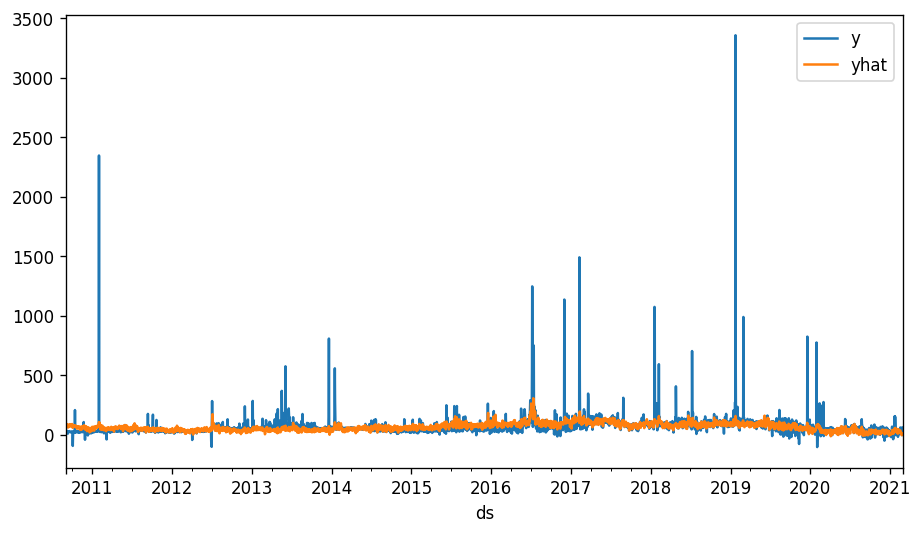

In [38]:
pd.concat([df_2.set_index('ds')['y'], forecast2.set_index('ds')['yhat']], axis=1).plot();

The model, though not perfect, has improved as compared to the univariate model.

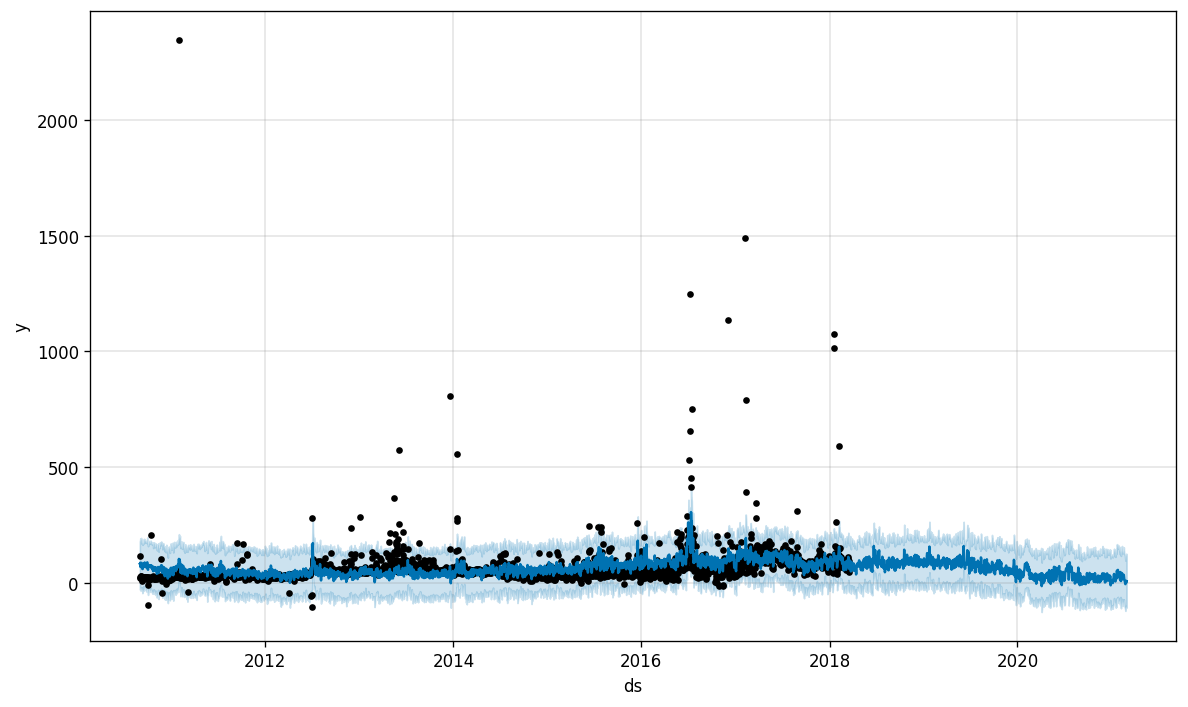

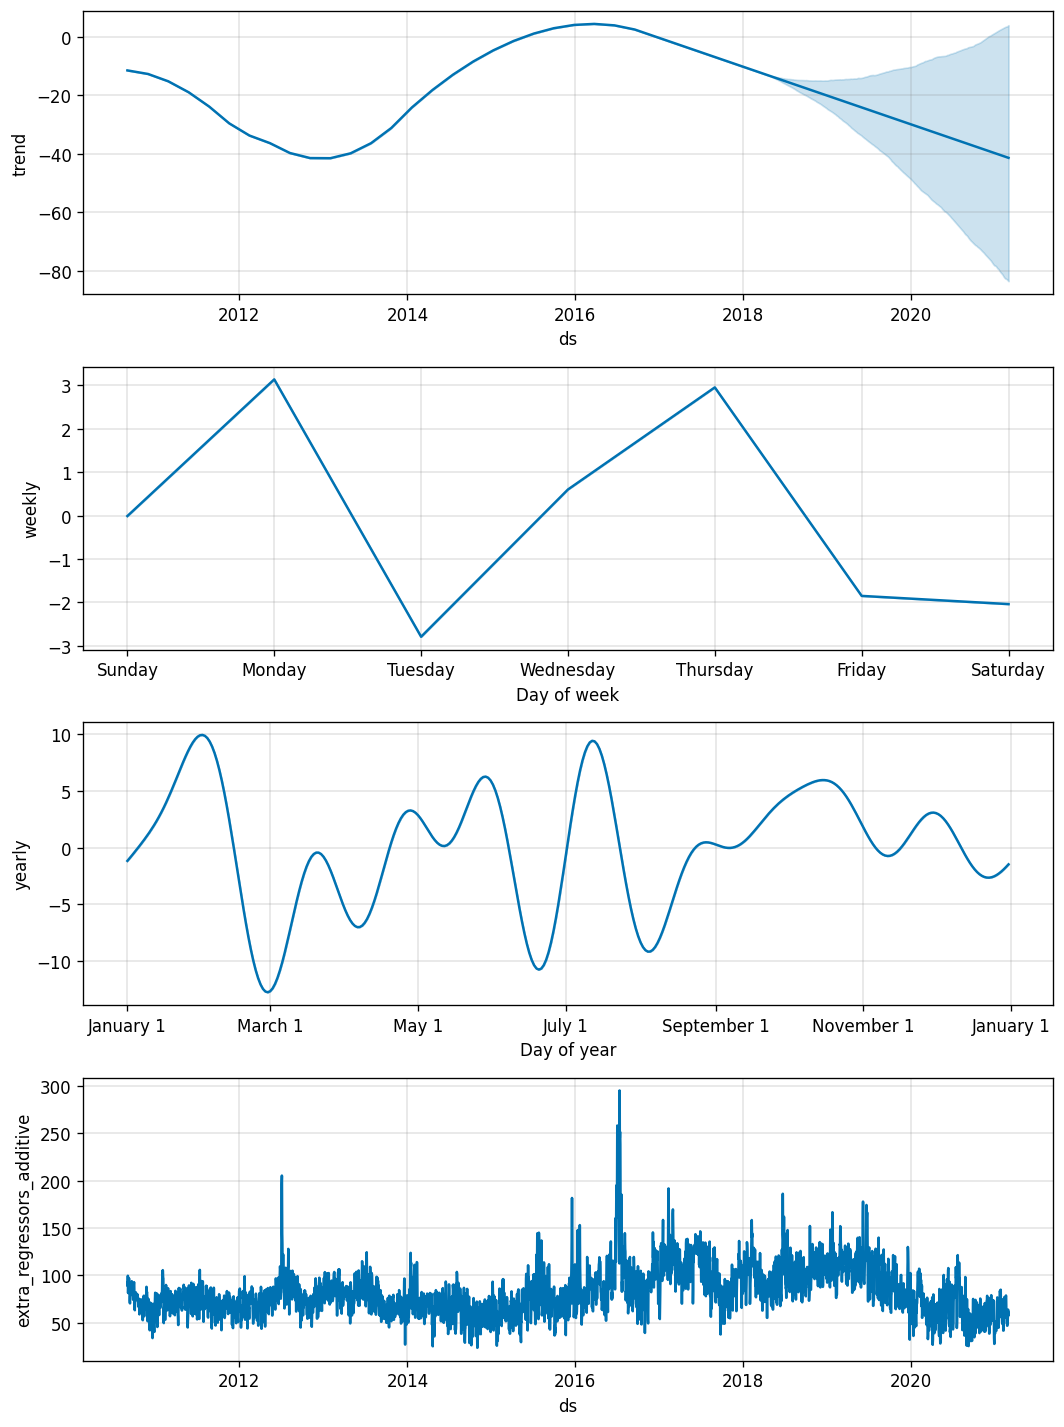

In [39]:
fig1 = m2.plot(forecast2) # Plot the fit to past data and future forcast.
fig2 = m2.plot_components(forecast2) # Plot breakdown of components.
plt.show()

In [42]:
# Extract the predicted values for the test set
predictions2 = forecast2[forecast2['ds'].isin(test['ds'])]['yhat']

# Calculate the MSE and MAE
mse = mean_squared_error(test['y'], predictions2)
mae = mean_absolute_error(test['y'], predictions2)
mape = mean_absolute_percentage_error(test['y'], predictions2)

print(f'{mse = :.2f}')
print(f'{rmse = :.2f}')
print(f'{mae = :.2f}')
print(f'{mape = :.2f}')

mse = 12547.77
rmse = 133.97
mae = 24.62
mape = 0.88


MSE, MAE and MAPE have reduced after adding regressors

In [43]:
df_3 = df_2.drop(columns='add2')
df_3.head()

,ds,y,add1,add3
0,2010-09-01,114.654167,1731.890833,3.69
1,2010-09-02,23.783750,1620.791250,3.69
2,2010-09-03,21.040625,1736.073333,4.45
3,2010-09-04,20.928125,1484.920208,3.39
4,2010-09-05,20.856458,1483.808750,4.45


In [44]:
new_train = df_3.iloc[:2757]
new_test = df_3.iloc[2757:]

new_train.shape,new_test.shape

((2757, 4), (1077, 4))

In [ ]:

model3 = Prophet()
model3 = model3.fit(new_train)

In [46]:
forecast3 = model3.predict(new_test)
forecast3.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,112.062029,7.015652,208.076336,112.062029,112.062029,-6.455844,-6.455844,-6.455844,0.406020,0.406020,0.406020,-6.861864,-6.861864,-6.861864,0.0,0.0,0.0,105.606185
1,2018-03-21,112.095802,12.627479,209.374005,112.095802,112.095802,-0.101269,-0.101269,-0.101269,6.640283,6.640283,6.640283,-6.741551,-6.741551,-6.741551,0.0,0.0,0.0,111.994534
2,2018-03-22,112.129576,18.874685,210.975296,112.129576,112.129576,3.990593,3.990593,3.990593,10.713432,10.713432,10.713432,-6.722839,-6.722839,-6.722839,0.0,0.0,0.0,116.120169
3,2018-03-23,112.163350,16.743413,207.365570,112.163350,112.163350,-4.704029,-4.704029,-4.704029,2.094815,2.094815,2.094815,-6.798844,-6.798844,-6.798844,0.0,0.0,0.0,107.459321
4,2018-03-24,112.197123,1.791129,189.310975,112.197123,112.197123,-18.270249,-18.270249,-18.270249,-11.310752,-11.310752,-11.310752,-6.959497,-6.959497,-6.959497,0.0,0.0,0.0,93.926874


In [47]:
# Extract the predicted values for the test set
pred = forecast3[forecast3['ds'].isin(new_test['ds'])]['yhat']

# Calculate the MSE and MAE
mse = mean_squared_error(new_test['y'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(new_test['y'], pred)
mae = mean_absolute_percentage_error(new_test['y'], pred)

print(f'{mse = :.2f}')
print(f'{rmse = :.2f}')
print(f'{mae = :.2f}')
print(f'{mape = :.2f}')

mse = 17947.82
rmse = 133.97
mae = 5.48
mape = 0.88
